In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.0.0'

forward/back propagation calculations https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c

Vanishing gradient example: https://github.com/harinisuresh/VanishingGradient/blob/master/Vanishing%20Gradient%20Example.ipynb

https://adventuresinmachinelearning.com/vanishing-gradient-problem-tensorflow/

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

%matplotlib inline

# Visualizing and understanding vanishing gradients

Make sure you understand well the backpropagation algorithm. You may perform by hand the calculations as illustrated [here](https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c) to consolidate your understanding.

We will be using three activation functions. Observe under which what values each function's gradient becomes negligible (very near zero)



### sigmoid

$$\text{sigm(z)} = \frac{1}{1-e^{-z}}$$

$$\frac{\partial \;\text{sigm}}{\partial \; z} = \text{sigm}(z)(1-\text{sigm}(z))$$


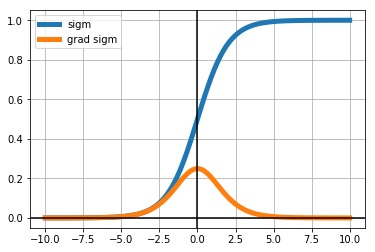

In [5]:
z = np.linspace(-10,10,100)

sigm = lambda z: 1/(1+np.exp(-z))

dsigm = lambda z: sigm(z)*(1-sigm(z))

plt.plot(z, sigm(z), lw=5, label="sigm")
plt.plot(z, dsigm(z), lw=5, label="grad sigm")
plt.grid()
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### tanh

$$\text{tanh(z)} = \frac{e^z - e^{-z}}{e^z-e^{-z}}$$

$$\frac{\partial \;\text{tanh}}{\partial \; z} = 1-\text{tanh}(z)^2$$


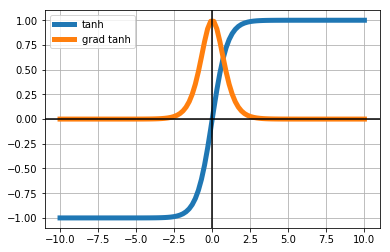

In [6]:
z = np.linspace(-10,10,100)

tanh = lambda z: (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

dtanh = lambda z: 1 - tanh(z)**2

plt.plot(z, tanh(z), lw=5, label="tanh")
plt.plot(z, dtanh(z), lw=5, label="grad tanh")
plt.grid()
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### ReLU (Rectified Linear Unit)

$$\text{relu}(z) = \text{z if }z<0\;;\;0\text{ otherwise}$$

$$\frac{\partial \;\text{relu}}{\partial \; z} = \text{1 if }z<0\;;\;0\text{ otherwise}$$


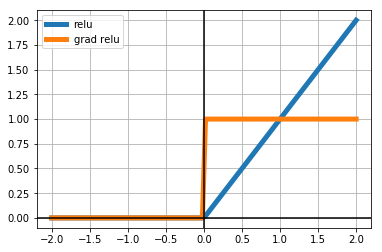

In [7]:
z = np.linspace(-2,2,100)

relu = np.vectorize(lambda z: z if z>0 else 0.)

drelu = np.vectorize(lambda z: 1 if z>0 else 0.)

plt.plot(z, relu(z), lw=5, label="relu")
plt.plot(z, drelu(z), lw=5, label="grad relu")
plt.grid()
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### Leaky ReLU (Rectified Linear Unit)

$$\text{relu}(z) = \text{z if }z<0\;;\;kz\text{ otherwise with }k<<1$$

$$\frac{\partial \;\text{relu}}{\partial \; z} = \text{1 if }z<0\;;\;k\text{ otherwise}$$


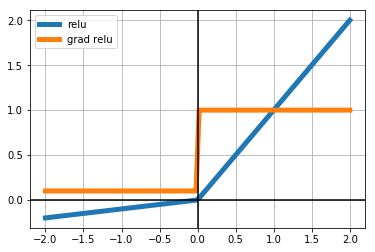

In [8]:
z = np.linspace(-2,2,100)

relu = np.vectorize(lambda z: z if z>0 else .1*z)

drelu = np.vectorize(lambda z: 1 if z>0 else .1)

plt.plot(z, relu(z), lw=5, label="relu")
plt.plot(z, drelu(z), lw=5, label="grad relu")
plt.grid(); 
plt.axvline(0, color="black");
plt.axhline(0, color="black");
plt.legend()

### load sample MNIST data as customary

In [10]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print(X_train.shape, y_train_oh.shape)

(1200, 784) (1200, 10)


In [12]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras

### A basic multi layered dense model

observe that the function allows us to parametrize the number of hidden layers and their activation function


In [13]:
def get_model(input_dim=784, output_dim=10, num_hidden_layers=6, hidden_size=10, activation="relu"):

    clear_session()
    model = Sequential()
    model.add(Dense(hidden_size, activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0)))
    
    for i in range(num_hidden_layers):
        model.add(Dense(hidden_size, activation=activation, name="Layer_%02d_Hidden"%(i+1)))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(num_hidden_layers+1)))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.reset_states()
    return model

### SIGMOID activation

In [14]:
model = get_model(num_hidden_layers=10, activation="sigmoid")
!rm -rf log/sigmoid
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/sigmoid', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

W0202 20:42:48.754888 140183790774080 callbacks.py:1468] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.


Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 1ms/sample - loss: 2.3192 - accuracy: 0.0883 - val_loss: 2.3112 - val_accuracy: 0.0600
Epoch 2/30
1200/1200 [==============================] - 0s 127us/sample - loss: 2.3044 - accuracy: 0.1158 - val_loss: 2.3135 - val_accuracy: 0.0600
Epoch 3/30
1200/1200 [==============================] - 0s 119us/sample - loss: 2.2994 - accuracy: 0.1158 - val_loss: 2.3108 - val_accuracy: 0.0600
Epoch 4/30
1200/1200 [==============================] - 0s 128us/sample - loss: 2.2972 - accuracy: 0.1125 - val_loss: 2.3139 - val_accuracy: 0.1133
Epoch 5/30
1200/1200 [==============================] - 0s 128us/sample - loss: 2.2962 - accuracy: 0.1267 - val_loss: 2.3136 - val_accuracy: 0.1133
Epoch 6/30
1200/1200 [==============================] - 0s 114us/sample - loss: 2.2962 - accuracy: 0.1267 - val_loss: 2.3152 - val_accuracy: 0.1133
Epoch 7/30
1200/1200 [==============================] - 0s 138us/sa

### RELU activation

In [15]:
model = get_model(num_hidden_layers=10, activation="relu")
!rm -rf log/relu
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/relu', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

W0202 20:43:13.222154 140183790774080 callbacks.py:1468] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.


Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 935us/sample - loss: 2.3022 - accuracy: 0.1125 - val_loss: 2.3022 - val_accuracy: 0.1000
Epoch 2/30
1200/1200 [==============================] - 0s 129us/sample - loss: 2.2943 - accuracy: 0.1442 - val_loss: 2.2637 - val_accuracy: 0.2000
Epoch 3/30
1200/1200 [==============================] - 0s 122us/sample - loss: 2.1472 - accuracy: 0.1983 - val_loss: 1.9569 - val_accuracy: 0.2467
Epoch 4/30
1200/1200 [==============================] - 0s 130us/sample - loss: 1.8373 - accuracy: 0.2600 - val_loss: 1.6961 - val_accuracy: 0.3167
Epoch 5/30
1200/1200 [==============================] - 0s 121us/sample - loss: 1.6749 - accuracy: 0.3150 - val_loss: 1.6003 - val_accuracy: 0.4067
Epoch 6/30
1200/1200 [==============================] - 0s 121us/sample - loss: 1.5848 - accuracy: 0.3858 - val_loss: 1.5412 - val_accuracy: 0.4200
Epoch 7/30
1200/1200 [==============================] - 0s 142us/

### Leaky RELU activation

In [16]:
import tensorflow as tf
model = get_model(num_hidden_layers=10, activation=tf.nn.leaky_relu)
!rm -rf log/leaky_relu
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/leaky_relu', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

W0202 20:43:19.326980 140183790774080 callbacks.py:1468] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.


Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 925us/sample - loss: 2.2777 - accuracy: 0.1158 - val_loss: 2.2411 - val_accuracy: 0.0600
Epoch 2/30
1200/1200 [==============================] - 0s 123us/sample - loss: 2.0914 - accuracy: 0.1667 - val_loss: 2.0801 - val_accuracy: 0.2267
Epoch 3/30
1200/1200 [==============================] - 0s 122us/sample - loss: 1.9926 - accuracy: 0.1958 - val_loss: 2.0226 - val_accuracy: 0.2333
Epoch 4/30
1200/1200 [==============================] - 0s 138us/sample - loss: 1.9168 - accuracy: 0.2175 - val_loss: 1.9278 - val_accuracy: 0.1900
Epoch 5/30
1200/1200 [==============================] - 0s 119us/sample - loss: 1.7532 - accuracy: 0.2725 - val_loss: 1.6522 - val_accuracy: 0.3700
Epoch 6/30
1200/1200 [==============================] - 0s 158us/sample - loss: 1.5806 - accuracy: 0.3317 - val_loss: 1.5161 - val_accuracy: 0.3733
Epoch 7/30
1200/1200 [==============================] - 0s 121us/

### SIGMOID activation but longer run (epochs)

In [17]:
model = get_model(num_hidden_layers=10, activation="sigmoid")
!rm -rf log/sigmoid_longrun
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/sigmoid_longrun', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
model.fit(X_train, y_train_oh, epochs=300, batch_size=32, validation_data=(X_test, y_test_oh), callbacks=[tb_callback])

W0202 20:43:25.362459 140183790774080 callbacks.py:1468] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.


Train on 1200 samples, validate on 300 samples
Epoch 1/300
1200/1200 [==============================] - 1s 1ms/sample - loss: 2.3434 - accuracy: 0.1158 - val_loss: 2.3412 - val_accuracy: 0.0600
Epoch 2/300
1200/1200 [==============================] - 0s 166us/sample - loss: 2.3168 - accuracy: 0.1158 - val_loss: 2.3269 - val_accuracy: 0.0600
Epoch 3/300
1200/1200 [==============================] - 0s 171us/sample - loss: 2.3048 - accuracy: 0.1158 - val_loss: 2.3189 - val_accuracy: 0.0600
Epoch 4/300
1200/1200 [==============================] - 0s 148us/sample - loss: 2.2997 - accuracy: 0.1158 - val_loss: 2.3162 - val_accuracy: 0.1133
Epoch 5/300
1200/1200 [==============================] - 0s 141us/sample - loss: 2.2976 - accuracy: 0.1125 - val_loss: 2.3166 - val_accuracy: 0.1133
Epoch 6/300
1200/1200 [==============================] - 0s 124us/sample - loss: 2.2966 - accuracy: 0.1267 - val_loss: 2.3161 - val_accuracy: 0.1133
Epoch 7/300
1200/1200 [==============================] - 0s 1

1200/1200 [==============================] - 0s 171us/sample - loss: 2.1117 - accuracy: 0.2092 - val_loss: 2.1398 - val_accuracy: 0.1467
Epoch 56/300
1200/1200 [==============================] - 0s 192us/sample - loss: 2.0756 - accuracy: 0.2100 - val_loss: 2.1123 - val_accuracy: 0.1467
Epoch 57/300
1200/1200 [==============================] - 0s 178us/sample - loss: 2.0498 - accuracy: 0.2092 - val_loss: 2.0884 - val_accuracy: 0.1500
Epoch 58/300
1200/1200 [==============================] - 0s 163us/sample - loss: 2.0273 - accuracy: 0.2100 - val_loss: 2.0735 - val_accuracy: 0.1500
Epoch 59/300
1200/1200 [==============================] - 0s 172us/sample - loss: 2.0269 - accuracy: 0.2025 - val_loss: 2.1226 - val_accuracy: 0.1233
Epoch 60/300
1200/1200 [==============================] - 0s 188us/sample - loss: 2.0203 - accuracy: 0.2008 - val_loss: 2.0554 - val_accuracy: 0.1933
Epoch 61/300
1200/1200 [==============================] - 0s 188us/sample - loss: 2.0123 - accuracy: 0.2083 - val

1200/1200 [==============================] - 0s 167us/sample - loss: 1.9051 - accuracy: 0.1967 - val_loss: 2.0022 - val_accuracy: 0.1533
Epoch 110/300
1200/1200 [==============================] - 0s 158us/sample - loss: 1.9179 - accuracy: 0.2008 - val_loss: 1.9954 - val_accuracy: 0.1400
Epoch 111/300
1200/1200 [==============================] - 0s 162us/sample - loss: 1.9179 - accuracy: 0.2008 - val_loss: 2.0013 - val_accuracy: 0.1433
Epoch 112/300
1200/1200 [==============================] - 0s 157us/sample - loss: 1.8985 - accuracy: 0.2017 - val_loss: 2.0015 - val_accuracy: 0.1433
Epoch 113/300
1200/1200 [==============================] - 0s 200us/sample - loss: 1.8964 - accuracy: 0.2092 - val_loss: 2.0055 - val_accuracy: 0.1433
Epoch 114/300
1200/1200 [==============================] - 0s 188us/sample - loss: 1.8988 - accuracy: 0.1983 - val_loss: 2.0105 - val_accuracy: 0.1933
Epoch 115/300
1200/1200 [==============================] - 0s 185us/sample - loss: 1.9035 - accuracy: 0.1933

1200/1200 [==============================] - 0s 367us/sample - loss: 2.0331 - accuracy: 0.2042 - val_loss: 2.0246 - val_accuracy: 0.2433
Epoch 164/300
1200/1200 [==============================] - 0s 357us/sample - loss: 1.9619 - accuracy: 0.2017 - val_loss: 1.9563 - val_accuracy: 0.2400
Epoch 165/300
1200/1200 [==============================] - 0s 249us/sample - loss: 1.9019 - accuracy: 0.1975 - val_loss: 1.9897 - val_accuracy: 0.1933
Epoch 166/300
1200/1200 [==============================] - 0s 256us/sample - loss: 1.8872 - accuracy: 0.2125 - val_loss: 1.9816 - val_accuracy: 0.1467
Epoch 167/300
1200/1200 [==============================] - 0s 380us/sample - loss: 1.9106 - accuracy: 0.2133 - val_loss: 1.9776 - val_accuracy: 0.1467
Epoch 168/300
1200/1200 [==============================] - 0s 352us/sample - loss: 1.8946 - accuracy: 0.2108 - val_loss: 1.9876 - val_accuracy: 0.1467
Epoch 169/300
1200/1200 [==============================] - 0s 278us/sample - loss: 1.8925 - accuracy: 0.2092

1200/1200 [==============================] - 0s 220us/sample - loss: 1.8427 - accuracy: 0.2117 - val_loss: 2.0001 - val_accuracy: 0.1467
Epoch 218/300
1200/1200 [==============================] - 0s 330us/sample - loss: 1.8405 - accuracy: 0.2117 - val_loss: 1.9998 - val_accuracy: 0.1467
Epoch 219/300
1200/1200 [==============================] - 1s 417us/sample - loss: 1.8406 - accuracy: 0.2117 - val_loss: 2.0019 - val_accuracy: 0.1467
Epoch 220/300
1200/1200 [==============================] - 1s 440us/sample - loss: 1.8405 - accuracy: 0.1775 - val_loss: 2.0019 - val_accuracy: 0.1433
Epoch 221/300
1200/1200 [==============================] - 1s 518us/sample - loss: 1.8419 - accuracy: 0.2017 - val_loss: 2.0046 - val_accuracy: 0.1467
Epoch 222/300
1200/1200 [==============================] - 1s 526us/sample - loss: 1.8366 - accuracy: 0.2125 - val_loss: 2.0041 - val_accuracy: 0.1467
Epoch 223/300
1200/1200 [==============================] - 1s 449us/sample - loss: 1.8376 - accuracy: 0.2067

1200/1200 [==============================] - 0s 284us/sample - loss: 1.8165 - accuracy: 0.2142 - val_loss: 1.9854 - val_accuracy: 0.1533
Epoch 272/300
1200/1200 [==============================] - 0s 232us/sample - loss: 1.8167 - accuracy: 0.2125 - val_loss: 1.9863 - val_accuracy: 0.1533
Epoch 273/300
1200/1200 [==============================] - 0s 203us/sample - loss: 1.8166 - accuracy: 0.2133 - val_loss: 1.9861 - val_accuracy: 0.1533
Epoch 274/300
1200/1200 [==============================] - 0s 235us/sample - loss: 1.8168 - accuracy: 0.2142 - val_loss: 1.9574 - val_accuracy: 0.1533
Epoch 275/300
1200/1200 [==============================] - 0s 185us/sample - loss: 1.8175 - accuracy: 0.1958 - val_loss: 1.9530 - val_accuracy: 0.1500
Epoch 276/300
1200/1200 [==============================] - 0s 188us/sample - loss: 1.8161 - accuracy: 0.2142 - val_loss: 1.9657 - val_accuracy: 0.1567
Epoch 277/300
1200/1200 [==============================] - 0s 167us/sample - loss: 1.8151 - accuracy: 0.2142

## Experiment observations

- What is the distribution of the gradients observed as we move from the output layer to the input layer for each experiment? 

- Might need to run for [Tensorboard](http://localhost:6006) to run:

      pip install --upgrade grpcio

- Look in [Tensorboard](http://localhost:6006) at distributions or histograms charts named `Layer_00_Input/kernel_0_grad`, `Layer_01_Hidden/kernel_0_grad`, etc. for different layers. You should see:
    - Gradients are usually higher at the output layer and tend to decrease as you move backwards in the network.
    - With sigmoid activations gradients are always low and rapidly decay from the output layer all the way to the input layer.
    - Relu might still have some vanishing gradient when weights are <0.
    - Leaky Relu would probably have constant gradients across layers.
    

- Recall that, in the backpropagation algorithm, the gradient of the loss function $L$ with respect to the weights at a certain layer $W_l$ is proportional to the derivatives and the weights of previous layers:

$$\frac{\partial L}{\partial W_l} \propto f'(z^{(l)})\cdot W_l \cdot f'(z^{(l+1)})\cdot W_{l+1} \cdot f'(z^{(l+2)})\cdot W_{l+2}...$$

where $f'$ is the derivative of the activation function and $z^{(l)}$ is the output at layer $l$.

- Do you think the sigmoid longrun would reach levels comparable to Relu or Leaky Relu? At what computational cost?
